In [1]:
import pandas as pd
import numpy as np
import torch
from transformers import AutoTokenizer, AutoModel
import joblib


/Users/Chris/.pyenv/versions/3.10.12/lib/python3.10/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [2]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(f"Using device: {device}")

model_name = "GroNLP/hateBERT"
tokenizer = AutoTokenizer.from_pretrained(model_name)
model = AutoModel.from_pretrained(model_name)
model.to(device)


Using device: cpu


BertModel(
  (embeddings): BertEmbeddings(
    (word_embeddings): Embedding(30522, 768, padding_idx=0)
    (position_embeddings): Embedding(512, 768)
    (token_type_embeddings): Embedding(2, 768)
    (LayerNorm): LayerNorm((768,), eps=1e-12, elementwise_affine=True)
    (dropout): Dropout(p=0.1, inplace=False)
  )
  (encoder): BertEncoder(
    (layer): ModuleList(
      (0-11): 12 x BertLayer(
        (attention): BertAttention(
          (self): BertSdpaSelfAttention(
            (query): Linear(in_features=768, out_features=768, bias=True)
            (key): Linear(in_features=768, out_features=768, bias=True)
            (value): Linear(in_features=768, out_features=768, bias=True)
            (dropout): Dropout(p=0.1, inplace=False)
          )
          (output): BertSelfOutput(
            (dense): Linear(in_features=768, out_features=768, bias=True)
            (LayerNorm): LayerNorm((768,), eps=1e-12, elementwise_affine=True)
            (dropout): Dropout(p=0.1, inplace=False

In [3]:
def get_hatebert_embeddings(texts, batch_size=16):
    embeddings = []
    total_batches = (len(texts) + batch_size - 1) // batch_size

    for i in range(0, len(texts), batch_size):
        batch_texts = texts[i:i+batch_size]
        encoded_input = tokenizer(
            batch_texts,
            padding=True,
            truncation=True,
            max_length=128,
            return_tensors='pt'
        ).to(device)

        with torch.no_grad():
            model_output = model(**encoded_input)

        sentence_embeddings = model_output.last_hidden_state[:, 0].cpu().numpy()
        embeddings.append(sentence_embeddings)

    return np.vstack(embeddings)


In [4]:
train_df = pd.read_csv("../data/train_data.csv")
test_df = pd.read_csv("../data/test_data_clean.csv")

X_train_text = train_df["text"]
y_train = train_df["label"]

X_test_text = test_df["comment"]
y_test = test_df["isHate"]

X_train_embed = get_hatebert_embeddings(X_train_text.tolist())
X_test_embed = get_hatebert_embeddings(X_test_text.tolist())

np.save("../data/X_train_hatebert.npy", X_train_embed)
np.save("../data/X_test_hatebert.npy", X_test_embed)
np.save("../data/y_train.npy", y_train)
np.save("../data/y_test.npy", y_test)


In [5]:
import numpy as np
import pandas as pd

X_train_hatebert = np.load("../data/X_train_hatebert.npy")
X_test_hatebert = np.load("../data/X_test_hatebert.npy")

train_df = pd.read_csv("../data/train_data.csv")
test_df = pd.read_csv("../data/test_data_clean.csv")

y_train = train_df["label"].astype(int)
y_test = test_df["isHate"].astype(int)


In [6]:
from sentence_transformers import SentenceTransformer
from sklearn.ensemble import RandomForestClassifier

rf_encoder = SentenceTransformer("all-MiniLM-L6-v2")

X_train_rf = rf_encoder.encode(train_df["text"].tolist(), show_progress_bar=True)
X_test_rf = rf_encoder.encode(test_df["comment"].tolist(), show_progress_bar=True)

rf_model = RandomForestClassifier(n_estimators=100, max_depth=None, class_weight="balanced", random_state=42)
rf_model.fit(X_train_rf, y_train)

rf_train_probs = rf_model.predict_proba(X_train_rf)[:, 1]
rf_test_probs = rf_model.predict_proba(X_test_rf)[:, 1]


Batches: 100%|██████████| 32/32 [00:02<00:00, 11.91it/s]


In [7]:
# stack BERT + RF predictions as features
X_train_stack = np.column_stack((X_train_hatebert, rf_train_probs))
X_test_stack = np.column_stack((X_test_hatebert, rf_test_probs))


In [8]:
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import classification_report

meta_model = LogisticRegression(max_iter=1000, class_weight="balanced")
meta_model.fit(X_train_stack, y_train)

y_pred = meta_model.predict(X_test_stack)
print(classification_report(y_test, y_pred))


              precision    recall  f1-score   support

           0       0.67      0.74      0.70       475
           1       0.74      0.67      0.70       523

    accuracy                           0.70       998
   macro avg       0.70      0.70      0.70       998
weighted avg       0.71      0.70      0.70       998



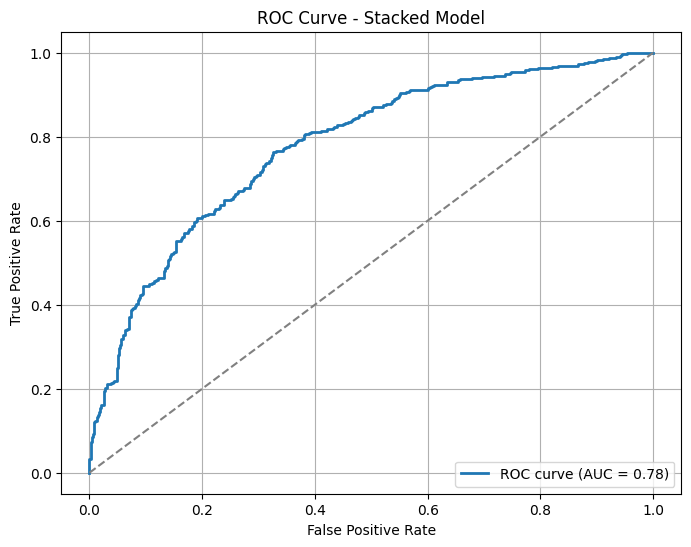

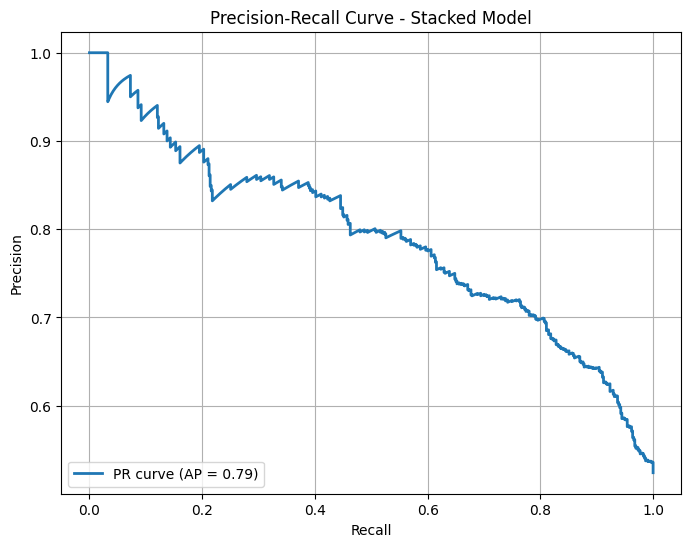

In [9]:
from sklearn.metrics import roc_curve, auc, precision_recall_curve, average_precision_score
import matplotlib.pyplot as plt

# get predicted probabilities for positive class
y_proba = meta_model.predict_proba(X_test_stack)[:, 1]

# ROC Curve
fpr, tpr, _ = roc_curve(y_test, y_proba)
roc_auc = auc(fpr, tpr)

plt.figure(figsize=(8, 6))
plt.plot(fpr, tpr, label=f"ROC curve (AUC = {roc_auc:.2f})", linewidth=2)
plt.plot([0, 1], [0, 1], linestyle="--", color="gray")
plt.xlabel("False Positive Rate")
plt.ylabel("True Positive Rate")
plt.title("ROC Curve - Stacked Model")
plt.legend(loc="lower right")
plt.grid(True)
plt.show()

# PR Curve
precision, recall, _ = precision_recall_curve(y_test, y_proba)
avg_prec = average_precision_score(y_test, y_proba)

plt.figure(figsize=(8, 6))
plt.plot(recall, precision, label=f"PR curve (AP = {avg_prec:.2f})", linewidth=2)
plt.xlabel("Recall")
plt.ylabel("Precision")
plt.title("Precision-Recall Curve - Stacked Model")
plt.legend(loc="lower left")
plt.grid(True)
plt.show()


In [10]:
import joblib
joblib.dump(meta_model, "../models/stacked_meta_model.pkl")
print("Meta-model saved to ../models/stacked_meta_model.pkl")


Meta-model saved to ../models/stacked_meta_model.pkl


In [11]:
np.save("../models/X_train_stack.npy", X_train_stack)
np.save("../models/X_test_stack.npy", X_test_stack)
print("Stacked features saved to ../models/")


Stacked features saved to ../models/
